# XY-calibration (QSO)

In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    os.chdir("/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe")
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from functools import reduce
import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
Elg = 1.0049 #2023 FTS #0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg =  1.0240 #2023 FTS #1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09245 ''/inc and Ce is 0.01024 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "QSO"
previous_xy_mapping = "Calibration/Mappings/2023/XY/QSO_XY_gamma1.00_230822.pkl"
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-0-QSO_230825_very_good_-100.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# load model from previous XY calib 
G2UV = Guider2UV(filename=previous_xy_mapping)
#changer de centre 
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.1038940*u.deg, 1.594590*u.deg), rotation=(90-100)*u.deg, gamma=1)#QSO1
		
	
# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1. 
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)

# # if you already know the approx angular distance between guidercenter and FOVcenter, set it:
# # G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
# #                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
# #                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
#     raise ValueError("Please verify the initialization mapping")
star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"

F1_stars = Table.read(star_target_path).to_pandas()

# stars =  [2, 4, 5, 6, 7] #QSOV 1
stars =  [13,14,15] #QSOV 1
selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))




FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.1913954, 0.01701968)>
FOV center pixel position in guider [array(1392.57797983), array(607.22190601)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-100.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (14.62883, 0.00512)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV c

/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_55941/492273298.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_55941/492273298.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))


## Alternative initialisation for new fields:
---------------------------------------

In [5]:

# f_ra, f_dec, f_rot = 0.038940, 1.394590, 90-100
# f_ra, f_dec, f_rot = 14.62883, 0.00512, 90-100
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )
                 


## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [6]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
# diffuse_offset = np.array([0.6,1.4])
diffuse_offset = np.array([0,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

['23', '36', '2', '13', '32', '11',"4"]

Here we struggled to find the good path because of faint 202/206 lines and of shadow of fiber holder

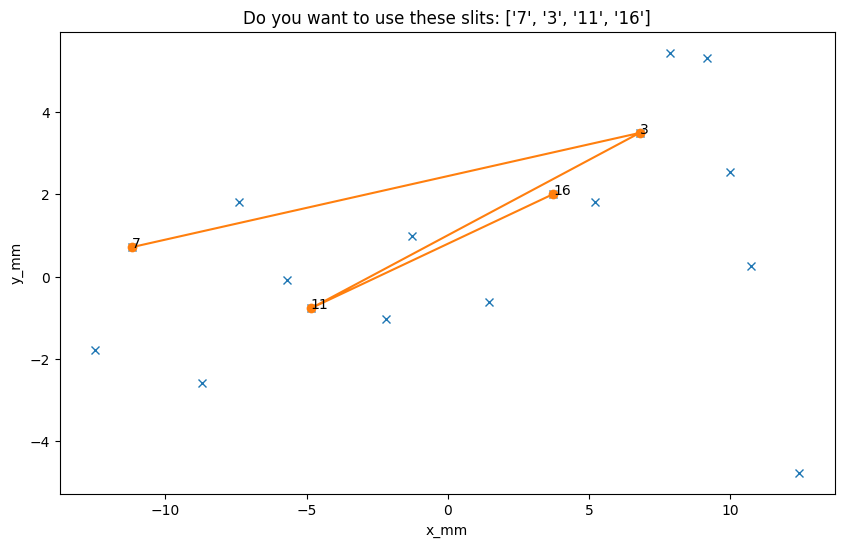

In [7]:
slits =[ '9', '16', '7',"3","10"]#pass only on QSO 3
slits =[  '7',"3","11","16"]# short pass
F1['Internal-count'] = F1['Internal-count'].astype(str)

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.ylabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path
selected_slits["g mag"]=np.nan
stars_and_slits = vstack([selected_stars["RA","DEC","Internal count","g mag"],selected_slits["RA","DEC","Internal-count","g mag"]])

In [8]:
selected_stars.to_pandas().to_clipboard()


The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [9]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 373.0 arcsec ; CE: -495.6 arcsec
EL: 490.6 arcsec ; CE: 252.7 arcsec
EL: 310.0 arcsec ; CE: -231.9 arcsec
EL: 427.6 arcsec ; CE: 125.4 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False the last move to return to the guider is not given. You just need to do -∑all moves
You should then add EL=427.6403 and CE=125.4252


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [10]:
# fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")
# ax1.plot(-46*selected_slits["x_mm"],46*selected_slits["y_mm"],"o")
# ax1.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")


In [11]:

slits_coord_obs_det = np.array([
[ 1704.4,	1978.5   ],
[ 1889.4,	590.5  ],
[ 1597.5,	1490.5   ],
[ 1786.4,	828.5   ],
]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.21161743, 0.27837879)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.27915708, -0.14150903)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.1776236, 0.13082989)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.24413289, -0.06949558)]>]

### look at siderostat frame hysteresis 

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

### check updating with fitting magnification

In [12]:
# G2UVtest=G2UV.copy()
# G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
# G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
# G2UVtest.FieldP.gamma = 1.
# print(G2UVtest)
# G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,inplace=False,selected_stars=stars_and_slits)


Fitting rotation and translation
theta: -22.2 arcmin
dx: -17.9 arcsec
dy: 5.7 arcsec
variances: [2.7762065  0.52044829 0.819824  ]

residuals in arcsec: [[  0.86342566 -11.98830658]
 [ -2.2032954    7.37655646]
 [  1.50346175  -2.21043363]
 [ -0.163592     6.82218375]]
max residual in EL,CE 2.2, 12.0 arcsec
mean residual in EL,CE 1.4, 7.9 arcsec
After updating:
    mask_rotation: -22.172634447913264 arcmin
    FOV center in guider: 1374.028271306291 x 608.5653523724807 pix = 671.5048437602328 arcsec x 62.50562819237008 arcsec arcsec
    mask_magnification correction: 1.0  
    
[ 0.01730345 -0.06669096 -0.14930021  0.20825218  0.27393842  0.17307397
  0.23875502] [-0.10535223  0.04906471  0.12853061  0.28244494 -0.14388803  0.13194715
 -0.07137712]
[ 0.0116479  -0.07135055 -0.15344727  0.20509783  0.26803433  0.16894894
  0.2333186 ] [-0.10388638  0.05107231  0.13107101  0.28267922 -0.14407741  0.13240832
 -0.07133959]


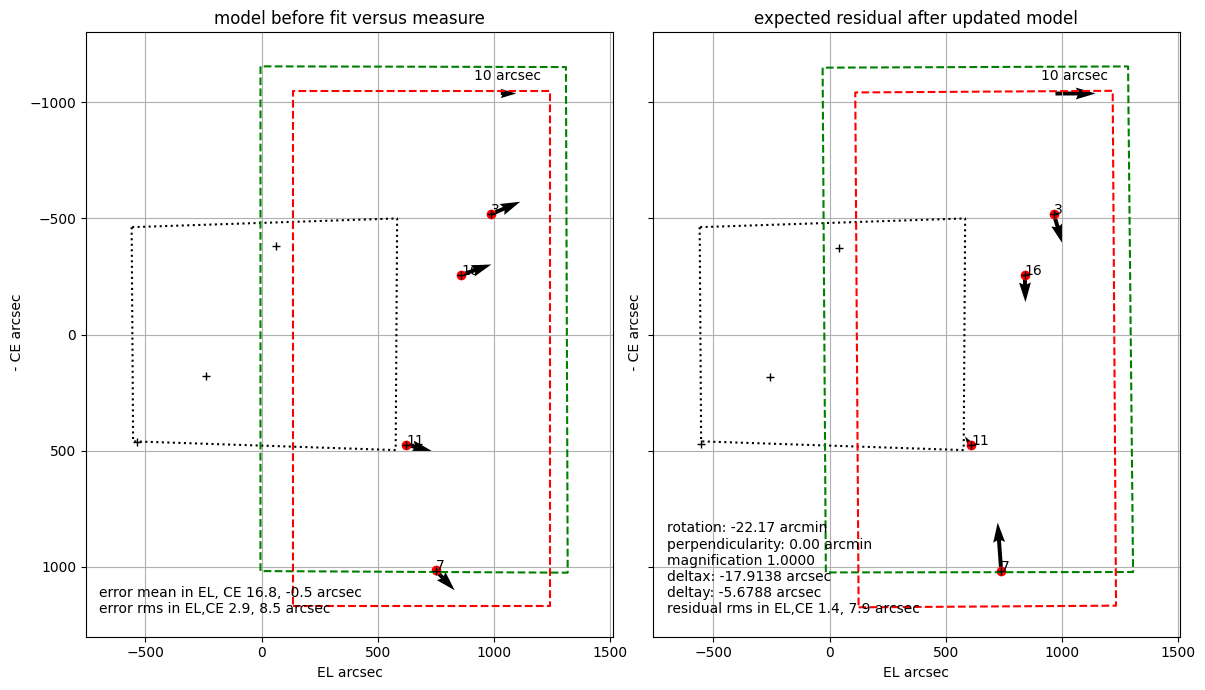


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [13]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7), labels=slits,gamma=False,selected_stars=stars_and_slits)


### Verify what magnification it predicts
### save corrected model for future use (eg redo the calib on same field)

# Another try in open mask

In [14]:
# slits =[  '7',"3","11","14"]# short pass
# selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

# selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves


slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]
slit position in mm on mask: [3.73474802 2.00093346]

targets local coords in siderostat local frame:
EL: 367.3 arcsec ; CE: -496.0 arcsec
EL: 480.0 arcsec ; CE: 253.0 arcsec
EL: 302.6 arcsec ; CE: -232.7 arcsec
EL: 417.9 arcsec ; CE: 125.4 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,367.312509,-496.015737,True,367.312509,-496.015737
1,112.668500,749.028075,True,479.981009,253.012338
2,-177.344259,-485.687208,True,302.636750,-232.674870
3,115.265975,358.033943,True,417.902725,125.359073


wave:  0.20619
Fitting rotation and translation
theta: -1.0 arcmin
dx: -0.3 arcsec
dy: -0.1 arcsec
variances: [2.77614875 0.52055739 0.80912946]

residuals in arcsec: [[  1.12490846 -12.0956324 ]
 [ -2.2326266    8.78849669]
 [  1.3954358   -3.07383394]
 [ -0.28771766   6.38096965]]
max residual in EL,CE 2.2, 12.1 arcsec
mean residual in EL,CE 1.4, 8.3 arcsec
After updating:
    mask_rotation: -23.15135213704726 arcmin
    FOV center in guider: 1373.777128149809 x 608.2506191274927 pix = 671.270631275907 arcsec x 62.213509154630906 arcsec arcsec
    mask_magnification correction: 1.0  
    
[ 0.0116479  -0.07135055 -0.15344727  0.20509783  0.26803433  0.16894894
  0.2333186 ] [-0.10388638  0.05107231  0.13107101  0.28267922 -0.14407741  0.13240832
 -0.07133959]
[ 0.011548   -0.07140649 -0.15348059  0.20510833  0.26792346  0.1689166
  0.23322838] [-0.10391796  0.05106464  0.13108686  0.28259327 -0.14418205  0.13233239
 -0.07143421]


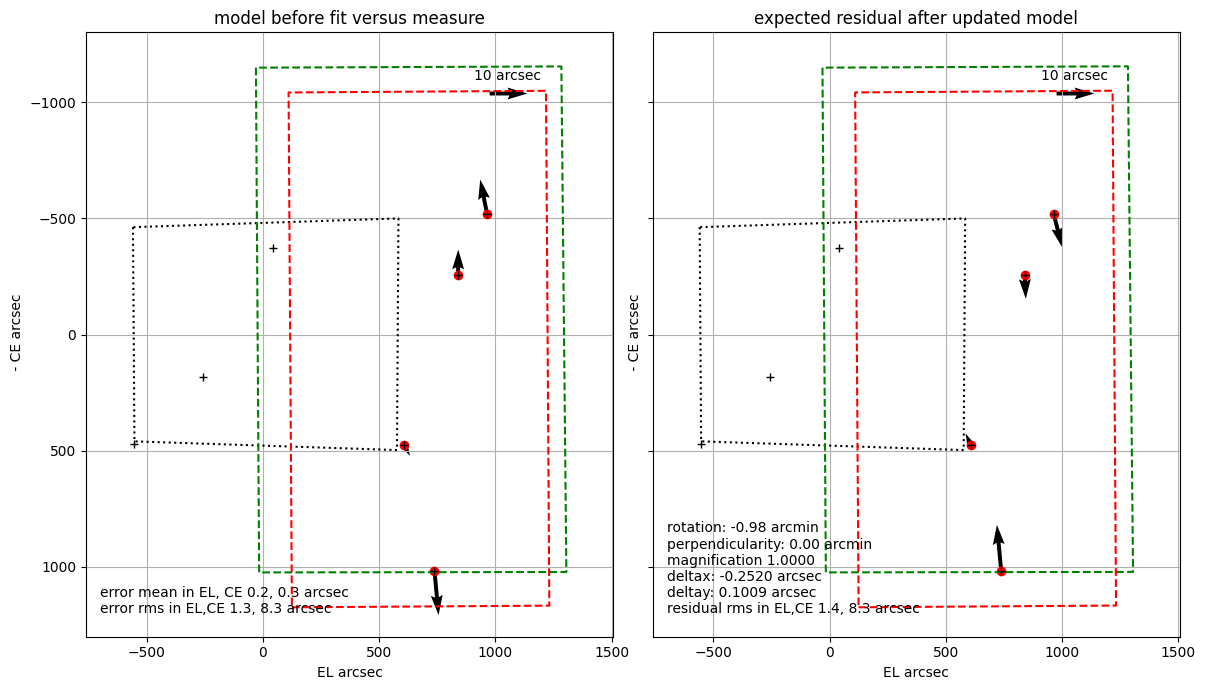


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [15]:
slits_coord_obs_det = np.array([
[ 1695.6	,1979.5   ],
[ 1872.4	,591.5 ],
[ 1585.5968	,1491.4921  ],
[ 1770.7	,828.5 ]])



valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7),gamma=False,selected_stars=stars_and_slits)#, labels=slits)#



In [16]:
# G2UVcor.save(filename="Calibration/Mappings/2023/XY/%s_XY_gamma%0.2f_%s_second_full_-100degrees.pkl"%(Field, G2UVcor.FieldP.gamma, datetime.datetime.now().strftime("%y%m%d")))



Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-100.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (14.62883, 0.00512)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: -23.15135213704726 arcmin
    FOV center in guider: 1373.777128149809x608.2506191274927 pix

Fitting rotation, translation and magnification
gamma: 1.013 
theta: -1.0 arcmin
dx: -10.9 arcsec
dy: -2.5 arcsec
variances: [8.07548938e-04 2.77614875e+00 8.21991783e-01 8.21991783e-01]

residuals in arcsec: [[ 0

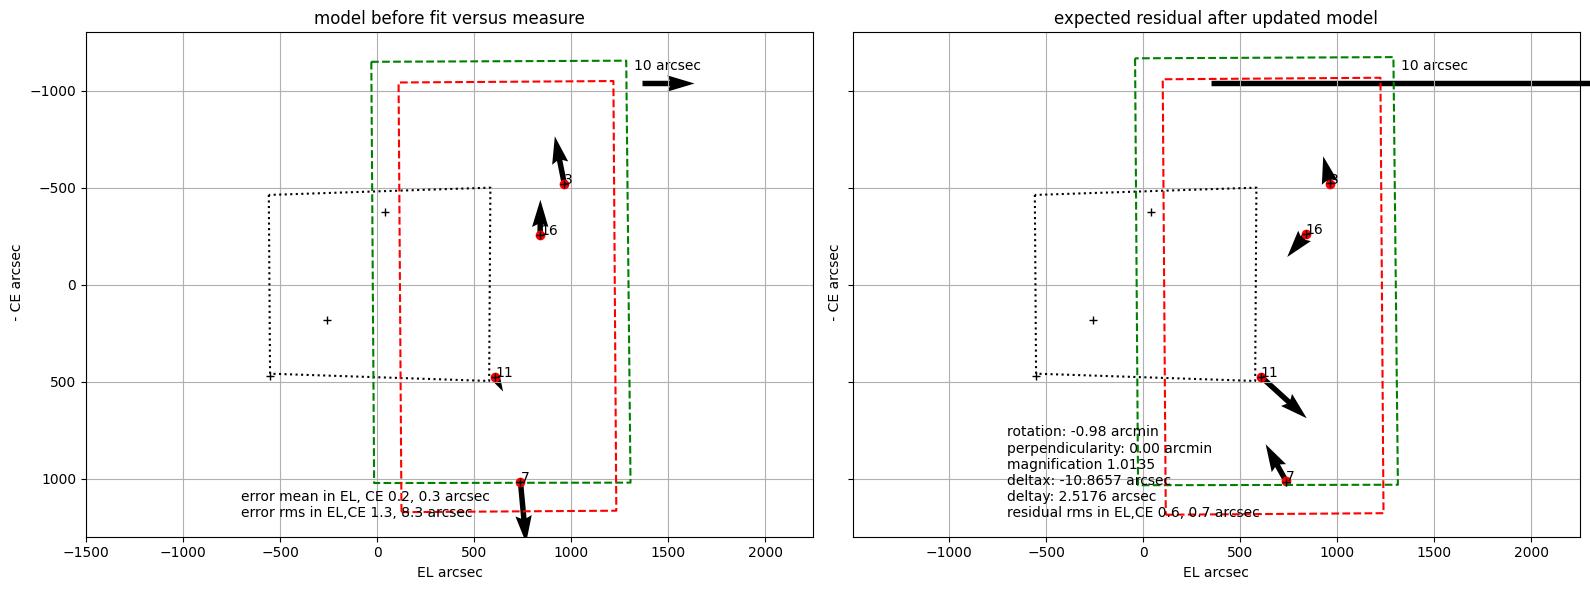


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [17]:
G2UVtest=G2UVcor.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,inplace=False,selected_stars=stars_and_slits)


In [18]:
# slits =[  '7',"3","11","14"]# short pass
# selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

# # selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

# moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
# moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# # assert moves.sum(axis=0)[0] <0.1
# # assert moves.sum(axis=0)[1] <0.1
# moves["UV_image"] = moves["UV_image"].astype(bool)
# moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
# moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# # slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# # slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# # slit_path
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# try:
#     moves.to_clipboard()
# except Exception as e:
#     print("Could not copy: ", e)
# moves


In [19]:
selected_slits.to_pandas().to_clipboard()

## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

In [20]:
slits =[ '9', '16', '7',"3","10"]#pass only on QSO 3
slits =[  '7',"3","11","16","4","1","14"]# short pass
F1['Internal-count'] = F1['Internal-count'].astype(str)

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

# new_cat = slit_path[:-1]
# new_cat["EL"] = moves["EL"][1:]
# new_cat["CE"] = moves["CE"][1:]

# new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
# new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
# new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # new_cat
# # new_cat.to_pandas().to_clipboard()



# plt.figure()
# plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
# plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
# plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
# plt.legend()
# plt.show()
# new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


slit position in mm on mask: [-11.19602978   0.71102989]
slit position in mm on mask: [6.79421478 3.48531442]
slit position in mm on mask: [-4.85520877 -0.7740052 ]
slit position in mm on mask: [3.73474802 2.00093346]
slit position in mm on mask: [10.74985227  0.24703836]
slit position in mm on mask: [-8.71595572 -2.59533058]
slit position in mm on mask: [9.97879885 2.54172577]

targets local coords in siderostat local frame:
EL: 367.3 arcsec ; CE: -495.9 arcsec
EL: 479.8 arcsec ; CE: 253.2 arcsec
EL: 302.6 arcsec ; CE: -232.5 arcsec
EL: 417.7 arcsec ; CE: 125.5 arcsec
EL: 341.4 arcsec ; CE: 416.8 arcsec
EL: 226.5 arcsec ; CE: -393.6 arcsec
EL: 438.9 arcsec ; CE: 385.4 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


EL,CE,UV_image,EL_abs,CE_abs
float64,float64,float64,float64,float64
367.3310728852898,-495.86468097259484,1.0,367.3310728852898,-495.86468097259484
112.45141675176822,749.0609267092309,1.0,479.782489637058,253.19624573663606
-177.20368880535182,-485.7376452706556,1.0,302.5788008317062,-232.54139953401955
115.16232270825017,358.0668027180082,1.0,417.74112353995633,125.52540318398866
-76.34021609457625,291.2940167103131,1.0,341.4009074453801,416.81941989430175
-114.91595700284441,-810.4543846549401,1.0,226.48495044253568,-393.63496476063835
212.39507203586268,779.0260620209331,1.0,438.88002247839836,385.3910972602947


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

# here we should not rerun the model because we tronc the fiber so we actually do not get the real center

# Again another iteration in open mask? NO


## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence We begin by QSO 5
 [29, 34, 18, 14]
we did not have the time to do this because G2UV was not well

In [21]:
# il faut que le centre soit bien defini à l'arcseconde pres.
# stars = [2, 4, 5, 6, 7]
# stars =  [13,14]#[2, 4, 5, 6, 7]
# selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363

star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves





targets local coords in siderostat local frame:
EL: 20.7 arcsec ; CE: 182.7 arcsec
EL: -127.9 arcsec ; CE: -89.8 arcsec
EL: -274.9 arcsec ; CE: -230.4 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,20.685045,182.668287,1.0
1,-148.589992,-272.430345,1.0
2,-147.013010,-140.664067,1.0


In [22]:
stars_path = vstack((selected_stars,selected_stars[::-1]) )
selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
print("(They have been copied to clipboard, paste it in the spreadsheet)")
star_moves.to_clipboard()


(They have been copied to clipboard, paste it in the spreadsheet)



targets local coords in siderostat local frame:
EL: 103.3 arcsec ; CE: -267.1 arcsec
EL: 283.2 arcsec ; CE: 77.9 arcsec
EL: 323.1 arcsec ; CE: 82.2 arcsec
EL: 167.7 arcsec ; CE: 128.0 arcsec
EL: 73.5 arcsec ; CE: 133.3 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [24]:
#back to guider center

stars =  [6,2, 4, 5, 7] #QSOV 1
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))


ra, dec, rot =0.03894, 1.39459, -10

G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)

# G2UVcor.save(filename="QSO1_XY_230825_Field1_second_full_-100degrees.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
# selected_stars.to_pandas().to_clipboard()

print("RA=%0.1f, DEC=%0.1f, rot=%s\n stars =  \n%s"%(ra, dec, rot ,selected_stars[selected_stars.colnames[:5]]))
# G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10, G2UVcor=None, selected_stars=selected_stars)



Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field1.pkl

targets local coords in siderostat local frame:
EL: 227.6 arcsec ; CE: -71.6 arcsec
EL: -3.1 arcsec ; CE: -45.1 arcsec
EL: 74.3 arcsec ; CE: -152.5 arcsec
EL: 85.9 arcsec ; CE: -139.7 arcsec
EL: 148.7 arcsec ; CE: -64.4 arcsec

siderostat moves sequence: 
RA=0.0, DEC=1.4, rot=-10
 stars =  
Internal count     RA       DEC      g mag     x deg  
-------------- ---------- -------- --------- ---------
             6     0.0266 1.331968   9.07557 -0.023024
             2   0.064613 1.207946 11.823838 -0.007133
             4 359.996741 1.239476 11.899264 -0.068484
             5   0.002719 1.247124  11.21874  -0.06127
             7   0.038536 1.289373 10.086621 -0.018669


In [25]:
selected_stars.to_pandas().to_clipboard()

In [27]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: 5.7 arcsec ; CE: -45.6 arcsec
EL: 83.4 arcsec ; CE: -152.3 arcsec
EL: 94.9 arcsec ; CE: -139.6 arcsec
EL: 236.3 arcsec ; CE: -71.2 arcsec
EL: 157.5 arcsec ; CE: -64.3 arcsec

siderostat moves sequence: 


In [26]:


stars = [10, 8, 12] #QSO7
#back to guider center
#Load new 
ra, dec, rot = 22.42638, 0.62279, 90-70
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
selected_stars.to_pandas().to_clipboard()
# G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field2.pkl")
print("RA=%0.1f, DEC=%0.1f, rot=%s\n stars =  \n%s"%(ra, dec, rot ,selected_stars[selected_stars.colnames[:5]]))

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363


RA=22.4, DEC=0.6, rot=20
 stars =  
Internal count     RA      DEC      g mag    x deg  
-------------- --------- -------- --------- --------
            10 22.470774 0.374579   7.73287  0.12661
             8 22.374342 0.385839 11.857352 0.032143
            12 22.455571 0.580502 10.246187 0.041892


In [28]:

star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
# G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10, G2UVcor=None, selected_stars=selected_stars)



targets local coords in siderostat local frame:
EL: -58.1 arcsec ; CE: 189.6 arcsec
EL: -97.1 arcsec ; CE: 23.3 arcsec
EL: 280.2 arcsec ; CE: 42.9 arcsec

siderostat moves sequence: 


In [30]:


stars = [20,  21] #QSOV 14
#back to guider center
ra, dec, rot = 351.8533, -1.8553, 0

G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(ra*u.deg, dec*u.deg), rotation=rot*u.deg, gamma=1)

selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO_field4_XY_230825_second_full_-100degrees.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves
print("RA=%0.1f, DEC=%0.1f, rot=%s\n stars =  \n%s"%(ra, dec, rot ,selected_stars[selected_stars.colnames[:5]]))
# G2UVcor.plot_fit([], [],residuals=[], labels=None, sol=None, figsize=(15,8), quiverscale=10, G2UVcor=None, selected_stars=selected_stars)


Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl

targets local coords in siderostat local frame:
EL: 159.6 arcsec ; CE: 128.4 arcsec
EL: 65.3 arcsec ; CE: 134.1 arcsec

siderostat moves sequence: 
RA=351.9, DEC=-1.9, rot=0
 stars =  
Internal count     RA        DEC      g mag    x deg  
-------------- ---------- --------- --------- --------
            20 351.944342 -1.952026  9.897263  0.09099
            21 351.947933 -2.004666 11.121481 0.094576


In [31]:


star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: 159.6 arcsec ; CE: 128.4 arcsec
EL: 65.3 arcsec ; CE: 134.1 arcsec

siderostat moves sequence: 


In [22]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,int64,int64,float64,float64
29,36.987137,0.402799,3.499382,-10.623502,10,--,--,375.60643978519715,274.037723163956
34,37.023638,0.390844,5.052622,-11.132199,9,--,--,329.09823563737774,119.62777354437654
18,36.877561,0.53311,-1.163312,-5.078307,--,12,11,905.7629054456784,724.3865249427333
14,36.867454,0.492628,-1.593376,-6.800959,--,13,12,743.471574722354,767.263365496059
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------